# Машинное обучение


Дан датафрейм, имеющий данные “Breast Cancer Wisconsin” (рак молочной железы, штат Висконсин). Имеются 30 признаков и бинарная целевая переменная (0 - рак не выявлен, 1 - рак выявлен). <br>

**Цель** - необходимо проанализировать датафрейм, определить вид машинного обучения, избрать несколько моделей обучения, определить метрики для сравнения моделей и определить лучшую из них. Так же необходимо выявить влияние каждой из характеристик на целевую переменную. <br>

**Ход исследования:**
- Предобработка данных
- Определение моделей, метрик
- Сравнение моделей по выбранным метрикам
- Определение степени влияния параметров
- Общий вывод

## 1 Выгрузка данных и их исследование

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mth

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from sklearn import datasets

### 1.1 Выгрузим тестовые данные и преобразуем их в датафрейм
<a id=1></a>
- [Выгрузка данных и их исследование](#1)
- [Постановка задачи и определение моделей ML](#2)
- [Определение степени влияния параметров](#3)
- [Общие выводы](#4)

In [2]:
try:
    df = datasets.load_breast_cancer()
    data = pd.DataFrame(df.data, columns=df.feature_names)
    data['target'] = df.target
except:
    print('Исправьте способ загрузки датасета')

In [3]:
print(df.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Размер датафрейма:

In [4]:
data.shape

(569, 31)

Выведем первые 5 строк:

In [5]:
display(data.head(5))
print(data.info())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

### 1.2 Переименуем столбцы

In [6]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

### 1.3 Обработка пропусков и явных дубликатов

Создадим функцию для автоматизации обработки

In [7]:
def data_info(data):
    print('Изучение общей информации\n', '-'*30)
    print('+'*30, '\nДубликаты\n', '-'*30)
    if data.duplicated().sum() == 0:
        print('Дубликатов нет')
    else:
        print(data.duplicated().sum())
    print('+'*30, '\nПропуски\n')
    print(data.isna().sum())

In [8]:
data_info(data)

Изучение общей информации
 ------------------------------
++++++++++++++++++++++++++++++ 
Дубликаты
 ------------------------------
Дубликатов нет
++++++++++++++++++++++++++++++ 
Пропуски

mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave_points        0
mean_symmetry              0
mean_fractal_dimension     0
radius_error               0
texture_error              0
perimeter_error            0
area_error                 0
smoothness_error           0
compactness_error          0
concavity_error            0
concave_points_error       0
symmetry_error             0
fractal_dimension_error    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave_points       0

### 1.4 Анализ неявных дубликатов и выбросов

Найдём все уникальные значения в столбцах типа object датафрейма, если это возможно; <br>
Выведем максимальные и минимальные значения столбцов типов datatime и float/int. <br>
Создадим для этого функцию и используем индивидуально для каждого датафрейма.

In [9]:
def dtype_columns(data):
    print("Датафрейм ")
    k = []
    list_object = []
    
    print("\nКоличество уникальный значений столбцов object\n")
    for i in data:
        if data[i].dtype == 'object':
            print(f"{i} - {len(data[i].unique())}")
            k.append(data[i].name)
    if len(k) == 0:
        print("отсутствуют\n")
    else:
        for i in k:
            if len(data[i].unique()) <= 15:
                list_object.append(data[i].name)
            
    k = []  
    
    print("\nДиапазон значений стобцов datetime64\n")
    for i in data:        
        if data[i].dtype == 'datetime64[ns]':
            print(f"{i}:\n max - {max(data[i])}\n min - {min(data[i])}\n")
            k.append(1)
    if len(k) == 0:
        print("отсутствуют\n")
    k = []
    
    print("Диапазон значений стобцов float64/int64\n")
    for i in data:
        if data[i].dtype == ('float64' or 'int64'):
            print(f"{i}:\n max - {max(data[i])}\n min - {min(data[i])}\n")
            k.append(1)
    if len(k) == 0:
        print("отсутствуют\n")
        
    print()    
    print("Выведем уникальные значения некоторых столбцов:\n")
    if len(list_object) != 0:
        for i in list_object:
            print(f'{data[i].name}:\n', f'{data[i].unique()}\n')
    else:
        print('Отсутствуют')

In [10]:
dtype_columns(data)

Датафрейм 

Количество уникальный значений столбцов object

отсутствуют


Диапазон значений стобцов datetime64

отсутствуют

Диапазон значений стобцов float64/int64

mean_radius:
 max - 28.11
 min - 6.981

mean_texture:
 max - 39.28
 min - 9.71

mean_perimeter:
 max - 188.5
 min - 43.79

mean_area:
 max - 2501.0
 min - 143.5

mean_smoothness:
 max - 0.1634
 min - 0.05263

mean_compactness:
 max - 0.3454
 min - 0.01938

mean_concavity:
 max - 0.4268
 min - 0.0

mean_concave_points:
 max - 0.2012
 min - 0.0

mean_symmetry:
 max - 0.304
 min - 0.106

mean_fractal_dimension:
 max - 0.09744
 min - 0.04996

radius_error:
 max - 2.873
 min - 0.1115

texture_error:
 max - 4.885
 min - 0.3602

perimeter_error:
 max - 21.98
 min - 0.757

area_error:
 max - 542.2
 min - 6.802

smoothness_error:
 max - 0.03113
 min - 0.001713

compactness_error:
 max - 0.1354
 min - 0.002252

concavity_error:
 max - 0.396
 min - 0.0

concave_points_error:
 max - 0.05279
 min - 0.0

symmetry_error:
 max - 0.07895
 

Найдём среди всех столбцов выбросы данных

In [11]:
print('Границы значений при 95 процентной и 99 процентной выборке:')
for i in data.columns:
    print(f'{i}  - {np.percentile(data[i], [95, 99])}')

Границы значений при 95 процентной и 99 процентной выборке:
mean_radius  - [20.576  24.3716]
mean_texture  - [27.15  30.652]
mean_perimeter  - [135.82  165.724]
mean_area  - [1309.8 1786.6]
mean_smoothness  - [0.11878  0.132888]
mean_compactness  - [0.2087   0.277192]
mean_concavity  - [0.24302  0.351688]
mean_concave_points  - [0.12574  0.164208]
mean_symmetry  - [0.23072  0.259564]
mean_fractal_dimension  - [0.07609   0.0854376]
radius_error  - [0.95952 1.29132]
texture_error  - [2.212   2.91544]
perimeter_error  - [7.0416  9.69004]
area_error  - [115.8   177.684]
smoothness_error  - [0.012644 0.017258]
compactness_error  - [0.060578 0.089872]
concavity_error  - [0.078936 0.122292]
concave_points_error  - [0.022884  0.0311936]
symmetry_error  - [0.034988 0.052208]
fractal_dimension_error  - [0.0079598 0.0126496]
worst_radius  - [25.64   30.7628]
worst_texture  - [36.3    41.8024]
worst_perimeter  - [171.64  208.304]
worst_area  - [2009.6  2918.16]
worst_smoothness  - [0.17184  0.1889

Построим графики распределения каждой из характеристик

C:\Users\griha\AppData\Local\Temp\ipykernel_10152\1636610802.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6,5))


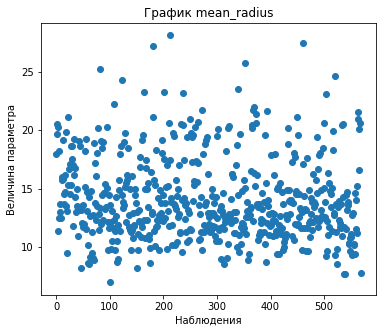

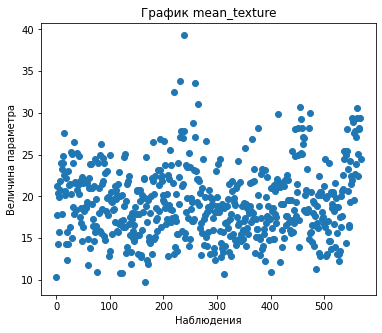

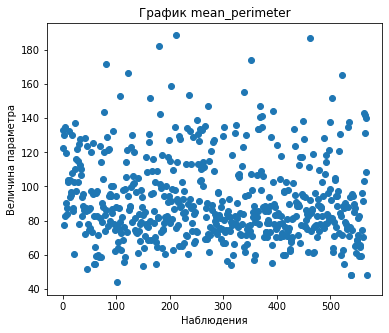

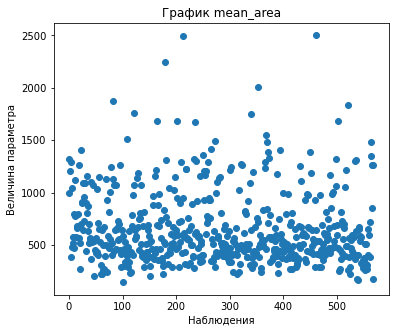

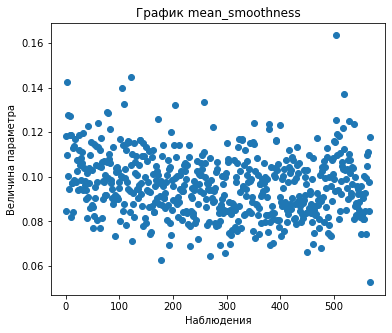

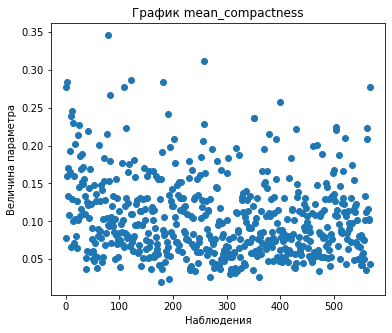

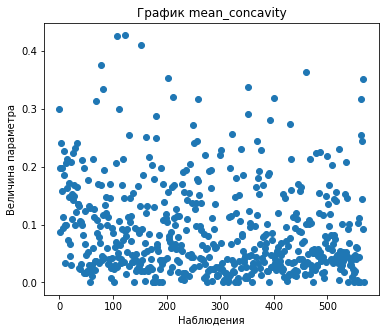

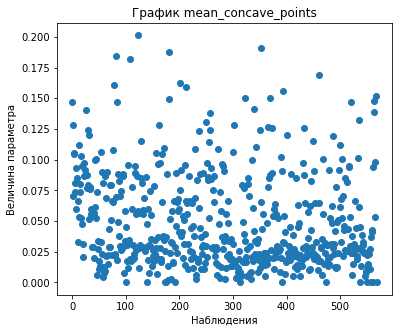

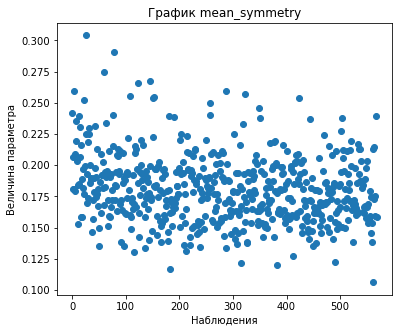

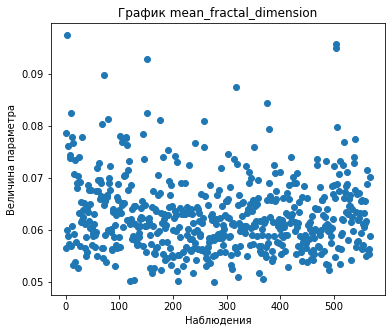

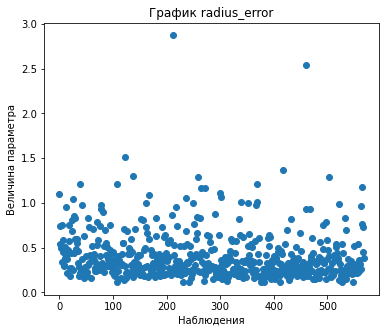

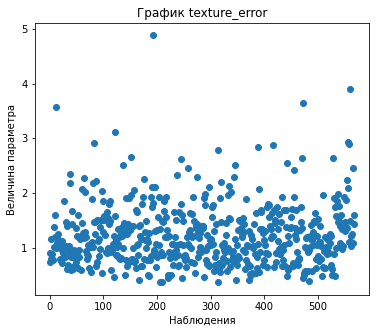

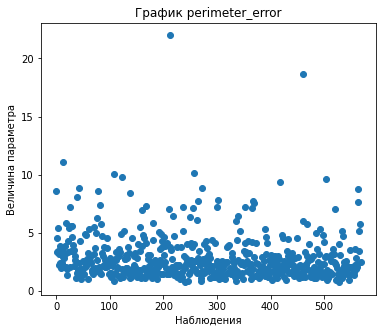

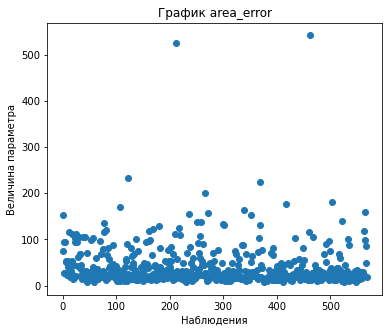

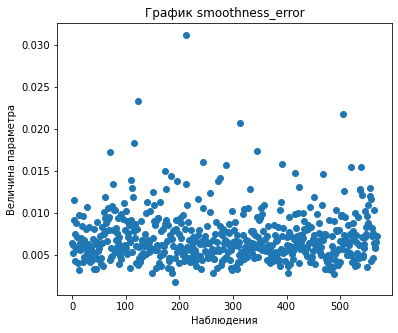

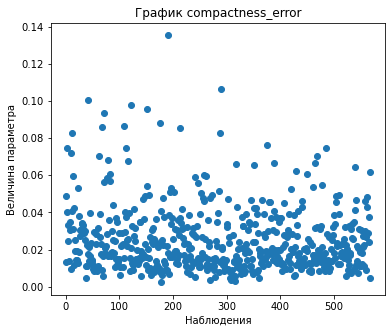

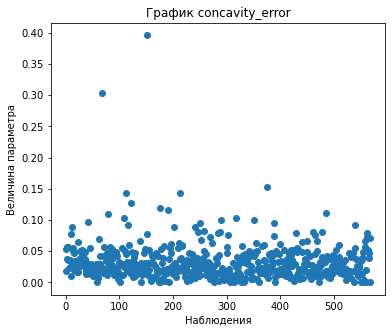

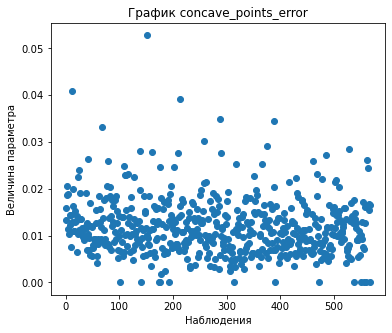

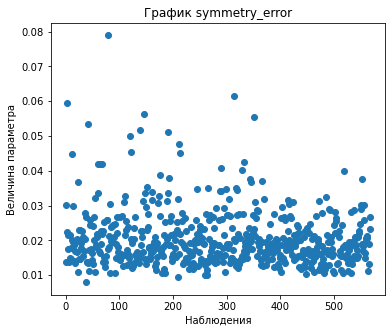

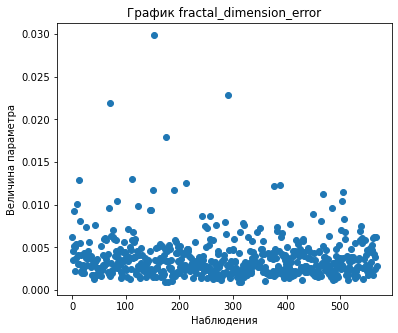

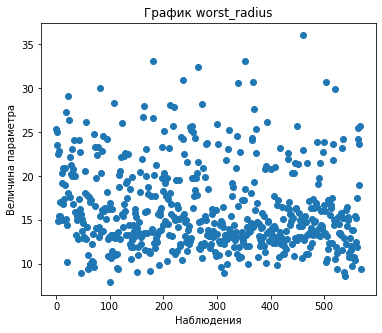

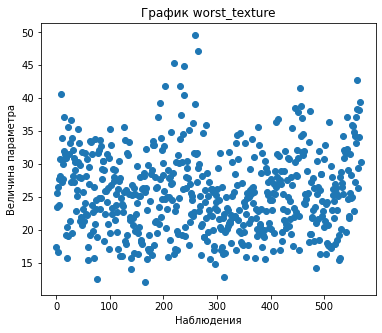

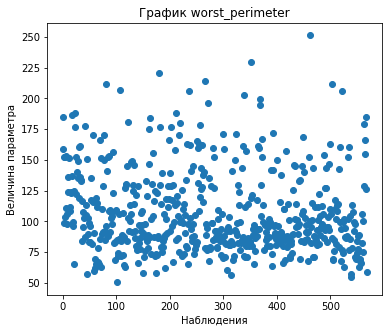

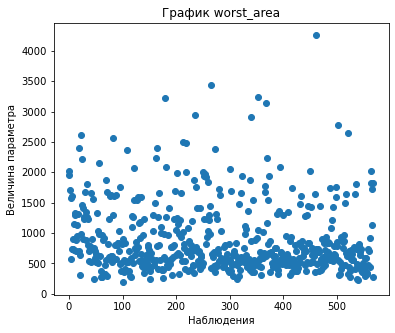

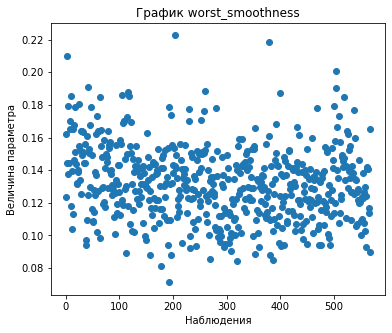

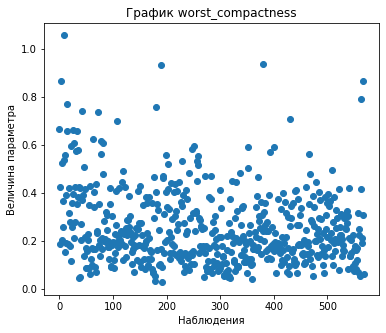

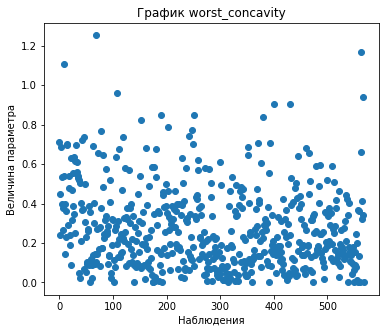

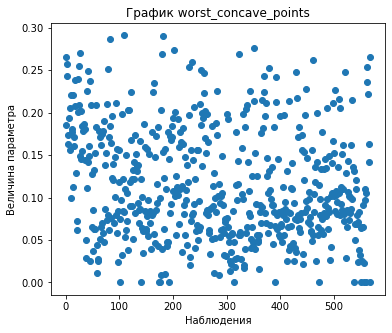

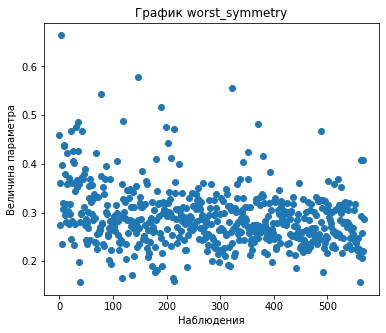

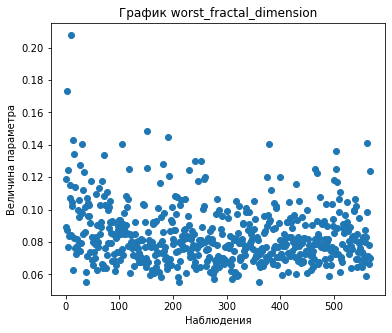

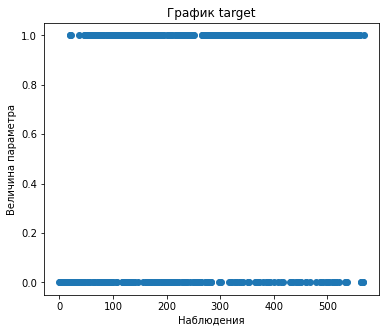

In [12]:
for i in data.columns:
    fig = plt.figure(figsize=(6,5))
    x_values = pd.Series(range(0,len(data[i])))
    #plt.ylim(data[i].max())
    plt.scatter(x_values, data[i])
    plt.title(f'График {i}')
    plt.xlabel('Наблюдения')
    plt.ylabel('Величина параметра');

Вычислим и удалим все данные, выходящие за верхний порог в 99 процентов выборки

In [13]:
list_percentile = []
for i in data.columns:
    list_percentile.append(np.percentile(data[i], [99])[0])

u = 0
for i in data.columns:
    i = str(i)
    data = data[data[i] <= list_percentile[u]]
    u += 1
print(data.shape)

(502, 31)


C:\Users\griha\AppData\Local\Temp\ipykernel_10152\1636610802.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6,5))


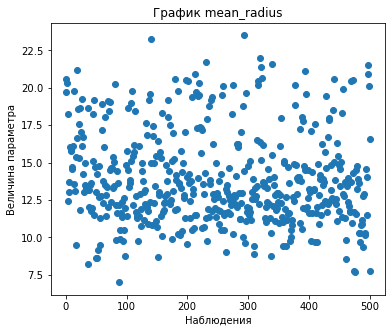

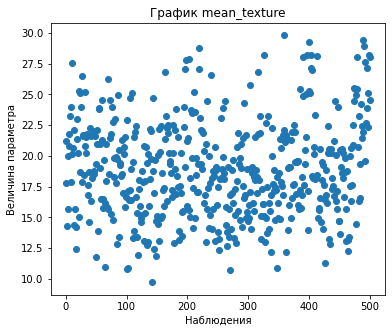

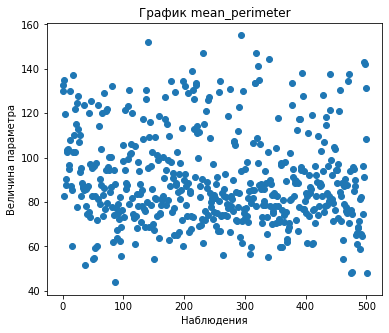

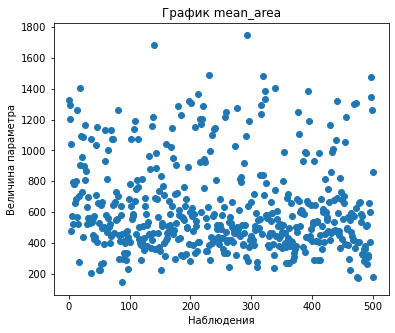

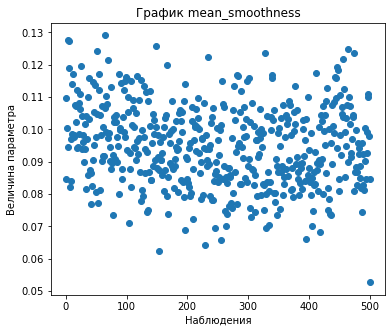

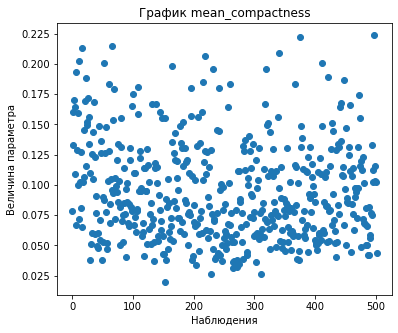

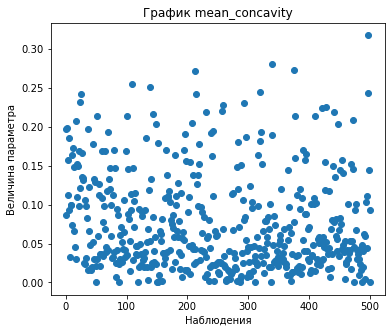

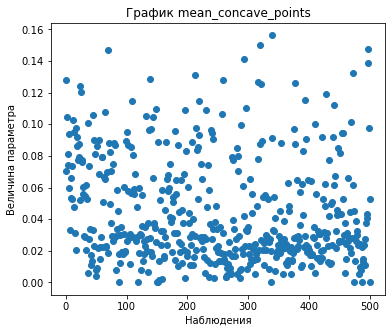

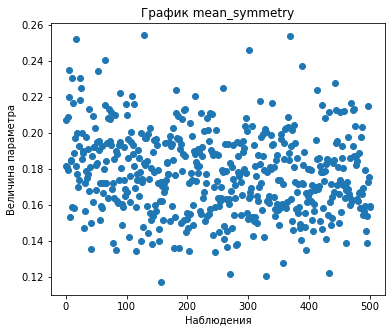

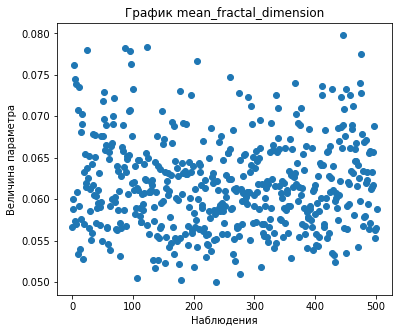

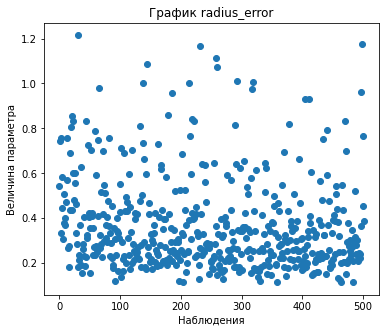

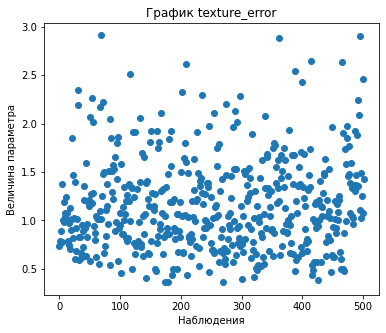

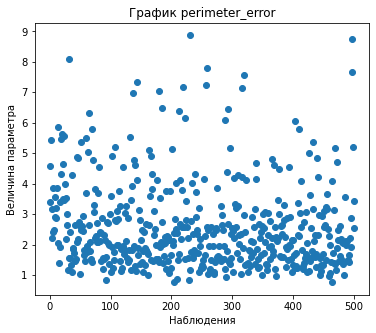

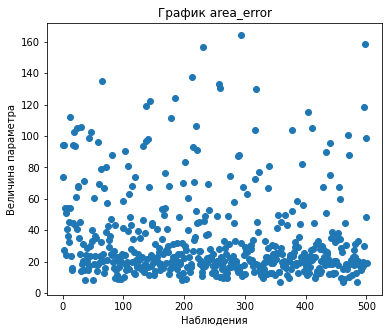

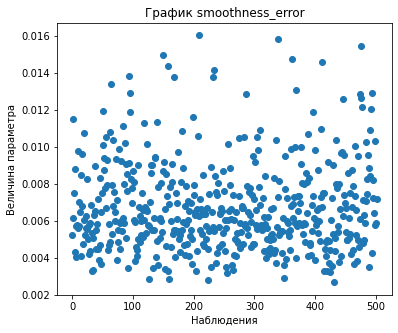

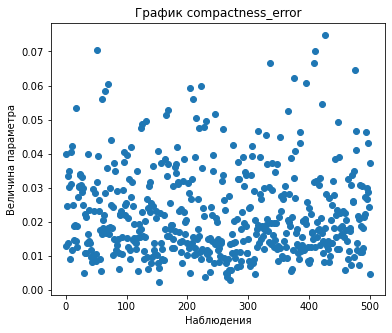

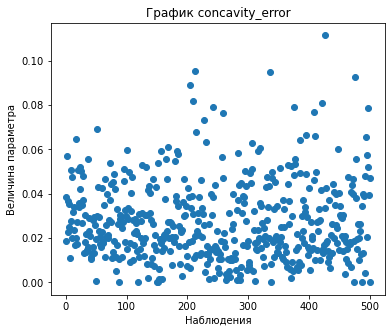

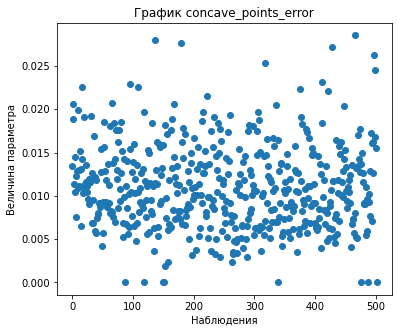

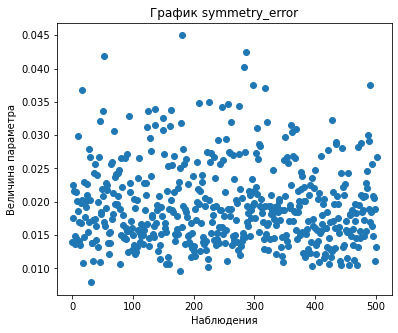

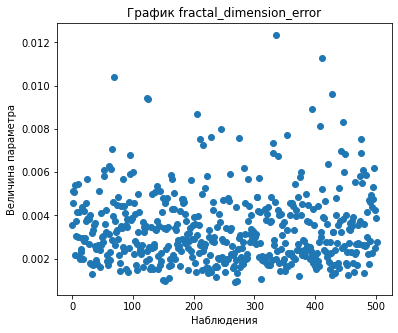

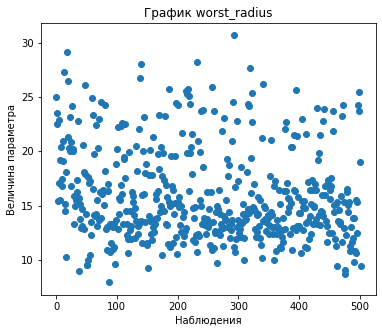

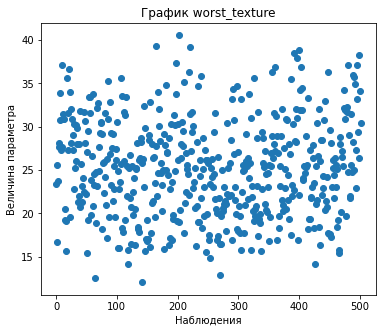

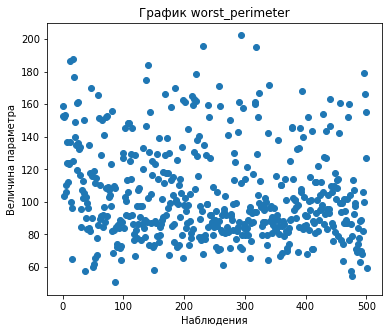

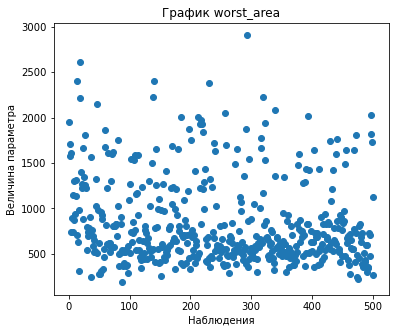

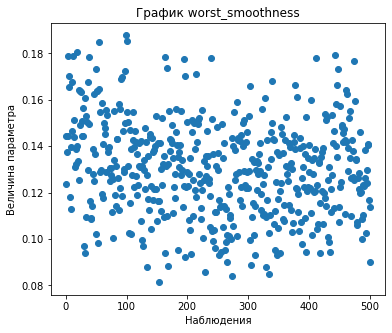

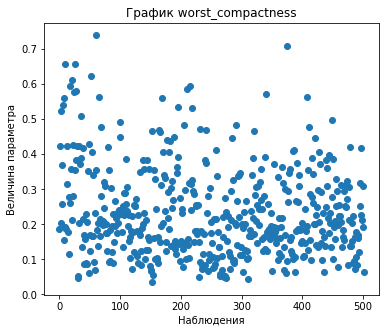

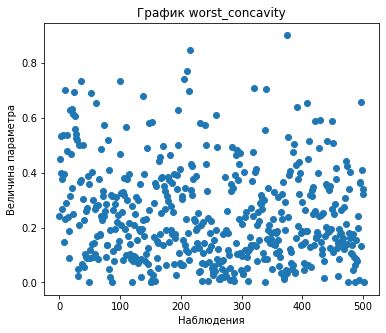

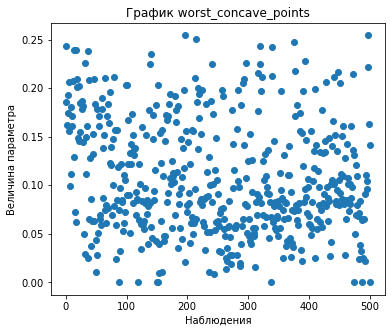

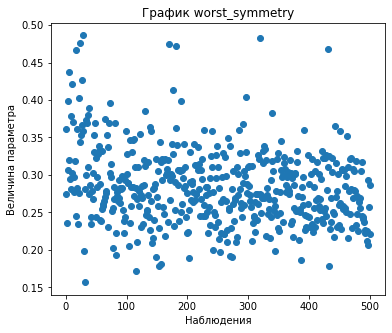

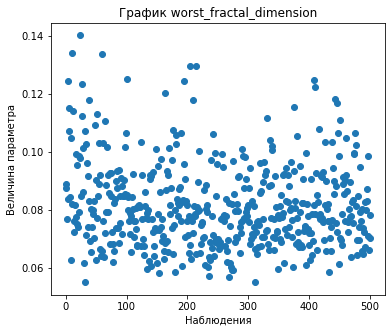

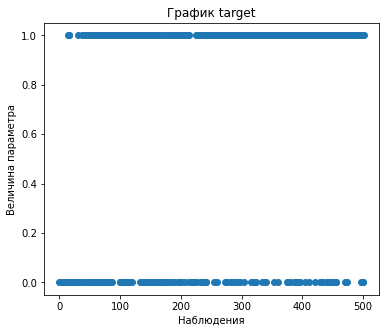

In [14]:
for i in data.columns:
    fig = plt.figure(figsize=(6,5))
    x_values = pd.Series(range(0,len(data[i])))
    #plt.ylim(data[i].max())
    plt.scatter(x_values, data[i])
    plt.title(f'График {i}')
    plt.xlabel('Наблюдения')
    plt.ylabel('Величина параметра');

**Вывод:** датафрейм преобразован, не имеет явных/не явных дубликатов. Исключены выбросы и аномалии, выходящие за пределы 98 процентов выборки. Датафрейм пригоден для дальнейшего использования.

## 2 Постановка задачи и определение моделей ML
<a id=2></a>
- [Выгрузка данных и их исследование](#1)
- [Постановка задачи и определение моделей ML](#2)
- [Определение степени влияния параметров](#3)
- [Общие выводы](#4)

### 2.1 Постановка задачи

Целевая переменная имеет бинарный вид и мы решаем задачу бинарной классификации. Для этой задачи возьмём несколько подходящих моделей: 
- Логистическая регрессия
- Решающее дерево
- Случайный лес
- Градиентный бустинг 

Данные модели могут быть сравнены друг с другом с помощью таких метрик, как:
- Accuracy (общая точность)
- Precision (точность)
- Recall (полнота)
- F1_score (гармоническое среднее между точностью и полнотой)
- ROC-AUC 

### 2.2 Обучение моделей

Напишем функцию для автоматизации обучения моделей классификации для датафреймов

In [15]:
def ML(data, model, test_size=0.2, random_state=0):
    
    #Разделим данные на параметры и целевую метрику
    X = data.drop('target', axis = 1)
    y = data['target']
    
    #Разделим выборку на обучающую и валидационную
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    #Стандартизируем наши данные для дальнейшей обработки
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    
    #Зададим и обучим наши модели, сделаем прогнозы
    model = model
    model.fit(X_train_st, y_train)
    
    predict = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:, 1]
    
    #Напишем функцию для вывода всех наших метрик
    def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
        print(title)
        print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
        print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
        print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
        print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
        print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))
        
    return print_all_metrics(y_test, predict, probabilities)

Зададим список всех наших моделей

In [16]:
model_list = [LogisticRegression(random_state=0), DecisionTreeClassifier(random_state=0),\
              RandomForestClassifier(n_estimators = 100, random_state=0), \
              GradientBoostingClassifier(n_estimators = 100, random_state=0)]

Сделаем перебор списка и выведем метрики каждой модели

In [17]:
for i in model_list:
    print(i)
    ML(data, i)
    print('\n')

LogisticRegression(random_state=0)
Метрики классификации
	Accuracy: 0.99
	Precision: 0.99
	Recall: 1.00
	F1: 0.99
	ROC_AUC: 0.99


DecisionTreeClassifier(random_state=0)
Метрики классификации
	Accuracy: 0.96
	Precision: 0.98
	Recall: 0.96
	F1: 0.97
	ROC_AUC: 0.96


RandomForestClassifier(random_state=0)
Метрики классификации
	Accuracy: 0.96
	Precision: 0.98
	Recall: 0.96
	F1: 0.97
	ROC_AUC: 0.99


GradientBoostingClassifier(random_state=0)
Метрики классификации
	Accuracy: 0.99
	Precision: 0.99
	Recall: 1.00
	F1: 0.99
	ROC_AUC: 0.99




### 2.3 Сравнение метрик

Исходя из полученных данных, лучшими моделями являются **градиентный бустинг**, поскольку для нашей задачи при одинковости остальных метрик, метрика Recall важнее, нежели Precesion (лучше поставить ложный положительный диагноз и отправить человека на доп облседование, чем пропустить  реальное заболевание).

## 3 Определение степени влияния параметров
<a id=3></a>
- [Выгрузка данных и их исследование](#1)
- [Постановка задачи и определение моделей ML](#2)
- [Определение степени влияния параметров](#3)
- [Общие выводы](#4)

Возьмём наилучшую модель и напишем функцию, которая выдаст вес каждого из параметров в конечной функции для определения целевой переменной

In [18]:
def final_model_importances(data, model, test_size=0.2, random_state=0):
    X = data.drop('target', axis = 1)
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    
    final_model = model
    final_model.fit(X_train_st, y_train)
    y_pred = final_model.predict(X_test_st)

    importances = pd.DataFrame(data=list(zip(X.columns, final_model.feature_importances_)),columns = ['name', 'weight'])
    return importances.sort_values(by='weight', ascending=False)

In [19]:
data_weight = final_model_importances(data, GradientBoostingClassifier(n_estimators = 100, random_state=0))
data_weight['weight'] = data_weight['weight'].round(4)
data_weight

,name,weight
22,worst_perimeter,0.3674
23,worst_area,0.3289
7,mean_concave_points,0.0780
27,worst_concave_points,0.0603
1,mean_texture,0.0481
21,worst_texture,0.0430
6,mean_concavity,0.0188
20,worst_radius,0.0118
13,area_error,0.0069
24,worst_smoothness,0.0047


**Вывод:** судя по таблице, наибольшее влияние имеет параметр worst perimeter (0,37)

## 4 Общие выводы
<a id=4></a>
- [Выгрузка данных и их исследование](#1)
- [Постановка задачи и определение моделей ML](#2)
- [Определение степени влияния параметров](#3)
- [Общие выводы](#4)

**Была проведена работа по выбору наилучшего алгоритма машинного обучения для бинарной классификации целевой переменной (определение наличие рака у обследуемого)**

**Перед началом работы поставлены задачи:**
- Предобработать данные для дальнейшей работы с ними;
- Определить вид обучения и подобрать алгоритмы;
- Определить метрики для сравнения моделей;
- Определить лучшую модель;
- Определить важность каждого из параметров и найти наиболее важный;


**В результате проведённой работы было выявлено следующее:**

1) Задача является вида - обучение с учителем, задача бинарной классификации.<br/>
2) Исходя из метрик, лучшей моделью является **Градиентный бустинг**.<br/>
- Accuracy: 0.99
- Precision: 0.99
- Recall: 1.00
- F1: 0.99
- ROC_AUC: 0.99 <br>

3) Самыми важными параметрами для модели являются: worst_perimeter - 0.37 и worst_area - 0.33 (веса).<br/>
    
**Общие рекомендации:**
Наибольшее внимание при анализе болезни уделять именно этим двум параметрам, так как именно они очень сильно влияют на возникновения рака.